# Preprocessing a Whole Slide Image

## Read a Slide

In LazySlide, the main data object you will work with is the `WSI` object.

You can load image either from **local** file or **remote URL** (http, ssh, s3, gcp), here we load a Esophagus slide from GTEx. To avoid waiting for downloading each time you run the code, you can specify a cache directory.

In [1]:
%config InlineBackend.figure_format = 'retina'
import lazyslide as zs

In [2]:
wsi = zs.WSI("https://brd.nci.nih.gov/brd/imagedownload/GTEX-1117F-1626", cache_dir="tmp")

/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The `WSI` object is a wrapper around `SpatialData` and a slide reading backend.

In [3]:
wsi

Slide: tmp/GTEX-1117F-1626
Backed Zarr: tmp/GTEX-1117F-1626.zarr
Reader: openslide
SpatialData object with:
├── Points
│     └── 'tiles': DataFrame with shape: (4396, 2) (2D points)
├── Shapes
│     ├── 'tissue_contours': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'tissue_holes': GeoDataFrame shape: (18, 1) (2D shapes)
└── Tables
      ├── 'tiles_resnet50': AnnData (4396, 1000)
      ├── 'tiles_table': AnnData (4396, 0)
      ├── 'tissue_contours_table': AnnData (6, 0)
      └── 'tissue_holes_table': AnnData (18, 0)
with coordinate systems:
▸ 'global', with elements:
        tiles (Points), tissue_contours (Shapes), tissue_holes (Shapes)

Let's check the slide metadata, this is a slide scan at 20X (magnification) with a mpp (micro per pixel) of 0.4942, it's shape is 40553 * 47807

In [4]:
wsi.metadata

Field,Value
mpp,0.4942
magnification,20.0
shape,"[40553, 47807]"
n_level,3
level_shape,"[[40553, 47807], [10138, 11951], [2534, 2987]]"
level_downsample,"[1.0, 4.0001748319017985, 16.004286728943022]"


We can first take a quick look at slide, what does it look like.

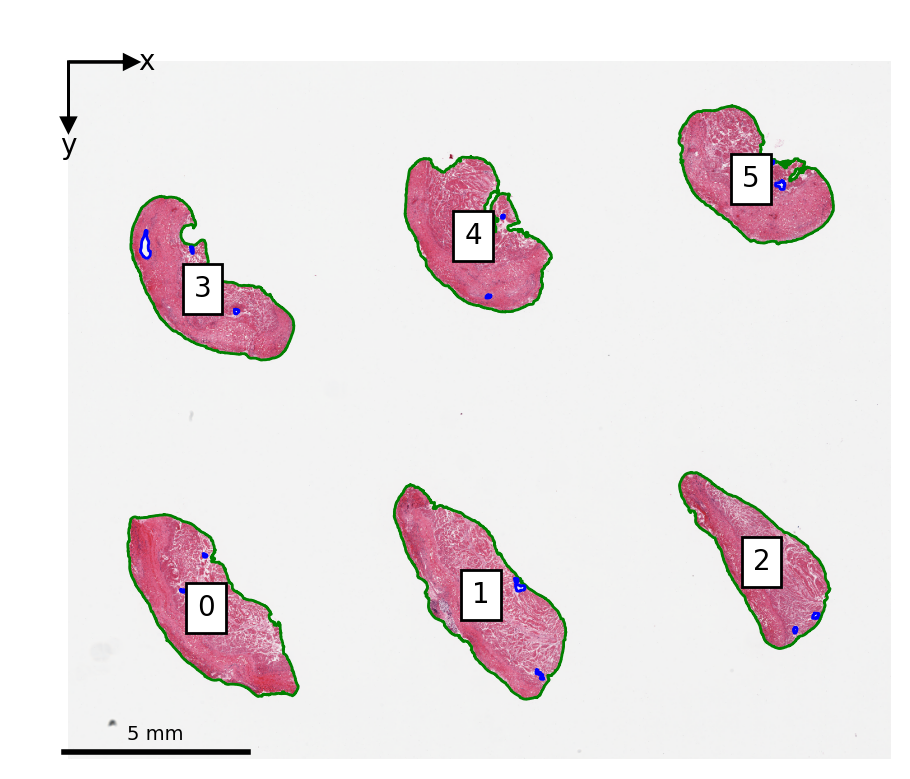

In [5]:
zs.pl.tissue(wsi)

## Tissue Segmentation

Before we proceed to other analysis, we need to segment the tissue from the slide.

We can take a quick look of the segmentation result, the <span style="color: green;">greens</span> are the tissue borders, the <span style="color: blue;">blues</span> are the holes that will be excluded.

The default parameters ususally works pretty well, but you may go ahead to adjust some parameters to fit your need.

In [6]:
zs.pp.find_tissue(wsi)
print(wsi)

Slide: tmp/GTEX-1117F-1626
Backed Zarr: tmp/GTEX-1117F-1626.zarr
Reader: openslide
SpatialData object with:
├── Points
│     └── 'tiles': DataFrame with shape: (4396, 2) (2D points)
├── Shapes
│     ├── 'tissue_contours': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'tissue_holes': GeoDataFrame shape: (18, 1) (2D shapes)
└── Tables
      ├── 'tiles_resnet50': AnnData (4396, 1000)
      ├── 'tiles_table': AnnData (4396, 0)
      ├── 'tissue_contours_table': AnnData (6, 0)
      └── 'tissue_holes_table': AnnData (18, 0)
with coordinate systems:
▸ 'global', with elements:
        tiles (Points), tissue_contours (Shapes), tissue_holes (Shapes)


/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `tissue_contours` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `tissue_contours_table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `tissue_holes` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `tissue_holes_table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


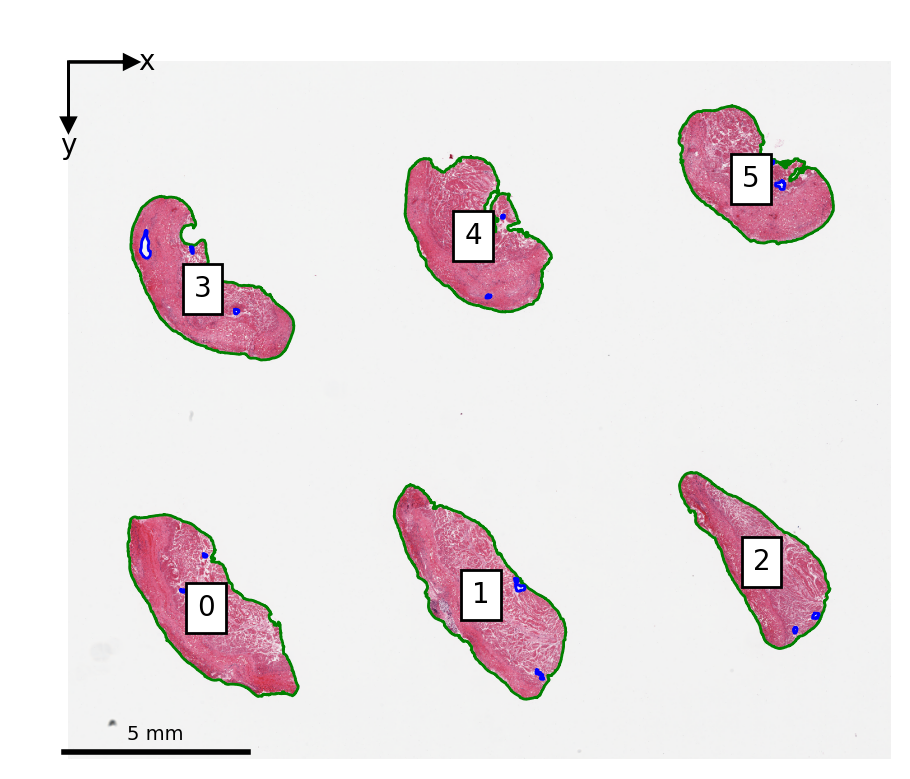

In [7]:
zs.pl.tissue(wsi)

We can also take a detail look on a specific tissue instance.

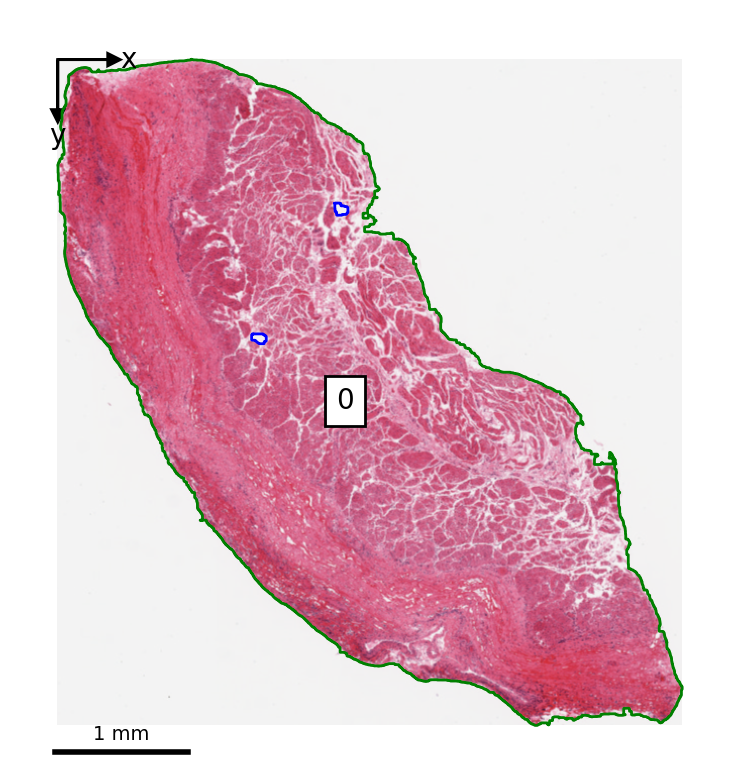

In [8]:
zs.pl.tissue(wsi, tissue_id=0)

## Tissue properties

You can quickly get the geometry properties of each tissue instances.

In [9]:
zs.tl.tissue_props(wsi)

In [41]:
wsi.get_shape_table('tissue_contours')[['id', 'area', 'solidity', 'convexity']]

,id,area,solidity,convexity
0,0,55804000.0,0.924663,1.081475
1,1,58963062.0,0.932358,1.072549
2,2,40264696.0,0.934153,1.070488
3,3,43992304.0,0.836904,1.194880
4,4,48931700.0,0.903757,1.106493
5,5,43636184.0,0.908001,1.101321


## Tiling

The slide images are usually too large to fit into memory, a widly adopted strategy is to create smaller tiles or patches.

```{note}
If you are working with many slides from different sources. Harmonization is very important to account for batch effects. In tiling steps, if your slides have different magnification, you should specify a mpp value that the tiling should works on.

Here is a list of mpp value map with magnification:

- 20X: mpp=0.5
- 40X: mpp=0.25

```

In [11]:
zs.pp.tiles(wsi, 256, mpp=0.5)
print(wsi)

Slide: tmp/GTEX-1117F-1626
Backed Zarr: tmp/GTEX-1117F-1626.zarr
Reader: openslide
SpatialData object with:
├── Points
│     └── 'tiles': DataFrame with shape: (<Delayed>, 2) (2D points)
├── Shapes
│     ├── 'tissue_contours': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'tissue_holes': GeoDataFrame shape: (18, 1) (2D shapes)
└── Tables
      ├── 'tiles_resnet50': AnnData (4396, 1000)
      ├── 'tiles_table': AnnData (4396, 0)
      ├── 'tissue_contours_table': AnnData (6, 0)
      └── 'tissue_holes_table': AnnData (18, 0)
with coordinate systems:
▸ 'global', with elements:
        tiles (Points), tissue_contours (Shapes), tissue_holes (Shapes)


/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:102: UserWarning: Key `tiles` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `tiles_table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


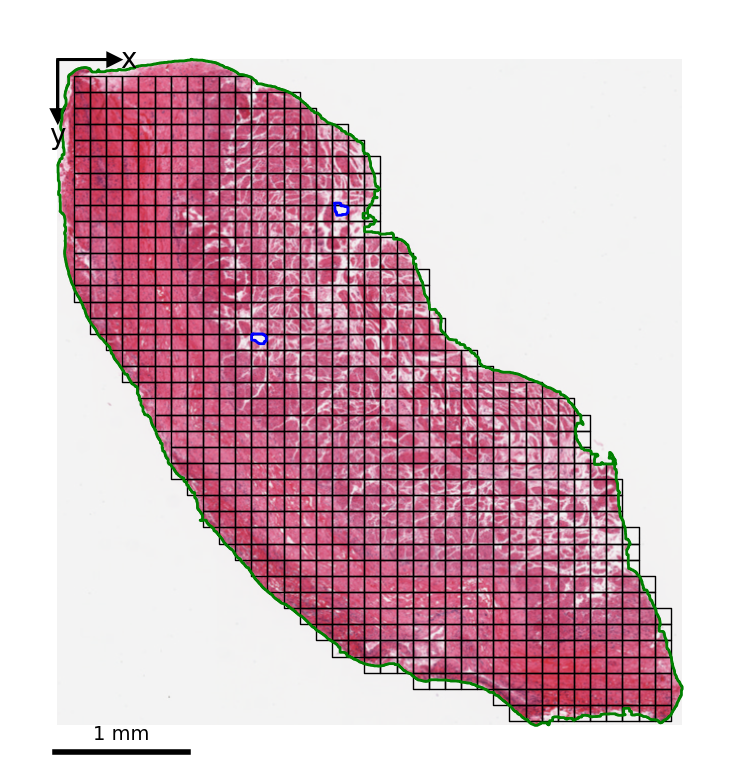

In [12]:
zs.pl.tiles(wsi, tissue_id=0, show_grid=True, show_point=False)

In [13]:
zs.pp.tiles_qc(wsi, scorers=["contrast"])

In [14]:
wsi.get_tiles_table('tiles')

,x,y,tissue_id,id,tile_key,contrast,qc
0,3704,26573,0,0,tiles,0.741176,True
1,3704,26829,0,1,tiles,0.537255,True
2,3704,27085,0,2,tiles,0.505882,True
3,3704,27341,0,3,tiles,0.509804,True
4,3704,27597,0,4,tiles,0.647059,True
...,...,...,...,...,...,...,...
4391,44189,7936,5,4391,tiles,0.811765,True
4392,44189,8192,5,4392,tiles,0.854902,True
4393,44189,8448,5,4393,tiles,0.803922,True
4394,44189,8704,5,4394,tiles,0.764706,True


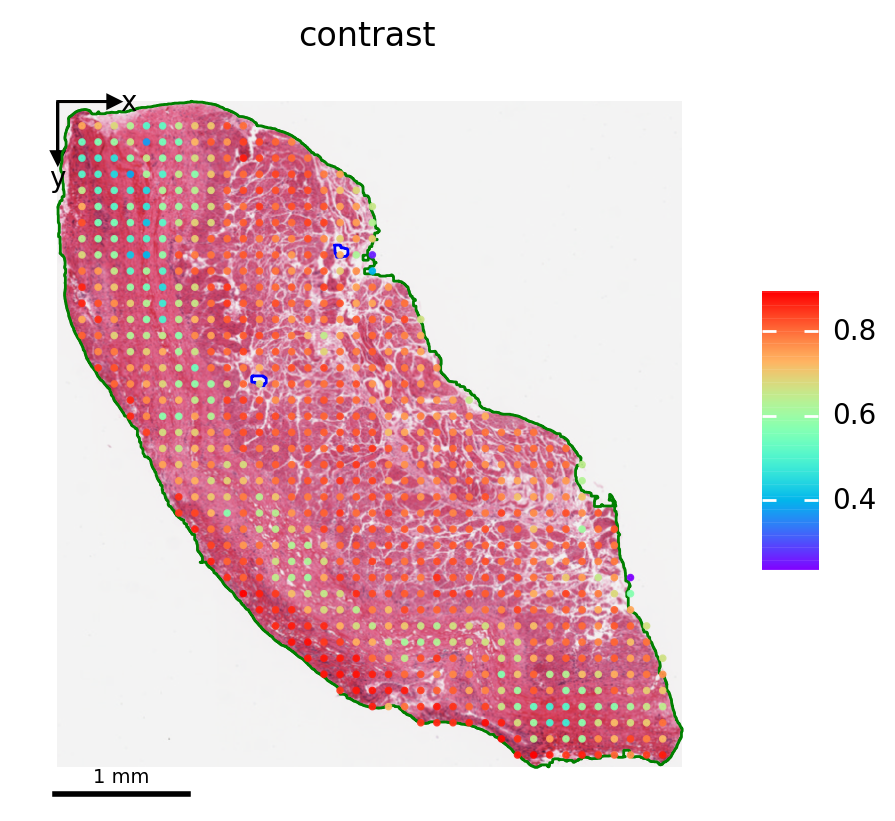

In [15]:
zs.pl.tiles(wsi, tissue_id=0, color='contrast', size=3)

## Feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

In [16]:
zs.tl.feature_extraction(wsi, 'resnet50', device="mps")

Output()

/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `tiles_resnet50` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


In [17]:
resnet50_f = zs.get.features_anndata(wsi, feature_key='resnet50')

In [18]:
resnet50_f

AnnData object with n_obs × n_vars = 4396 × 1000
    obs: 'x', 'y', 'tissue_id', 'id', 'tile_key', 'contrast', 'qc'
    uns: 'annotations', 'metadata', 'tile_spec', 'spatialdata_attrs'
    obsm: 'spatial'

In [19]:
wsi.write()